In [84]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from clusterer import Clusterer

# Ground-Truth

Load checkpoints

In [44]:
def load_checkpoint(path:str) -> np.ndarray:
    arr:np.ndarray = None
    with open(path, 'rb') as f:
        arr = np.load(f)
    return arr

In [45]:
# G_full:np.ndarray = load_checkpoint('checkpoints/G_full.pkl')
G_foreground:np.ndarray = load_checkpoint('checkpoints/G_foreground.pkl')

print(G_foreground[:2])
print(G_foreground.shape)

[[6.3289583e-05 5.2768064e-05 3.5819125e-05 ... 2.3706085e-05
  2.0665200e-05 7.2684639e-07]
 [7.3489988e-05 4.5792454e-05 3.1348951e-05 ... 3.6043770e-05
  1.3170381e-04 3.3057091e-05]]
(128, 1056)


Initialize clusterer

In [46]:
G_clusterer:Clusterer = Clusterer(G_foreground.T, [f'm-{i}' for i in range(0,128)])

Preview features

In [ ]:
G_df = pd.DataFrame(G_foreground.T, columns=[f'm-{i}' for i in range(0,128)])
G_df[:2]

Establish K with Kmeans

In [75]:
def search_param(method:callable, key:str, mn:int=2, mx:int=9, params:dict={}) -> int:
    ks:list = []
    for k in range(mn, mx):
        try:
            params.update({key: k})
            sil_score = method(params)
            ks.append((k, sil_score))
            # print((k, sil_score))
        except:
            break
    
    best:list = sorted(ks, key=lambda tup: tup[1], reverse=True)
    
    val, _ = best[0]
    
    #print('best: ', _, val)
    
    return val

In [78]:
G_k = search_param(G_clusterer.apply_kmeans, 'n_clusters', mn=2, mx=20,)
G_km_SilScore = G_clusterer.apply_kmeans({'n_clusters': G_k})
G_kmeans = G_clusterer.kmeans
G_km_labels:list = G_kmeans.labels_
    
print('Labels:', np.unique(G_km_labels, return_counts=True))
print('Silhouette Score:', G_km_SilScore)
print('Best K:', G_k)

Labels: (array([0, 1], dtype=int32), array([146, 910]))
Silhouette Score: 0.66730756
Best K: 2


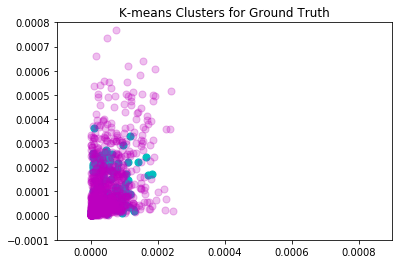

In [81]:
# { b, g, r, c, m, y, k, w }
    
G_primary_cluster = np.where(G_km_labels == 0)[0]
G_secondary_cluster = np.where(G_km_labels == 1)[0]

plt.xlim(-.0001, .0009)
plt.ylim(-.0001, .0008)

plt.title('K-means Clusters for Ground Truth')

plt.scatter(G_foreground.T[G_primary_cluster][:, 0], G_foreground.T[G_primary_cluster][:, 1], s=50, c='c');
plt.scatter(G_foreground.T[G_secondary_cluster][:, 0], G_foreground.T[G_secondary_cluster][:, 1], s=50, c='m', alpha=.25);


Find outliers with DBSCAN

In [72]:
G_min_cluster_size:int = search_param(G_clusterer.apply_hdbscan, 
                                      'min_cluster_size', 
                                       mn=2, mx=100, 
                                       params={})

best:  0.5277224 55
55


In [73]:
G_min_samples:int = search_param(G_clusterer.apply_hdbscan,
                                 'min_samples', 
                                 mn=2, mx=100,
                                 params={'min_cluster_size': G_min_cluster_size})

best:  0.5319491 49


In [82]:
G_hdb_SilScore:float = G_clusterer.apply_hdbscan({ # euclidean distance
    'min_cluster_size':G_min_cluster_size,
    'min_samples': G_min_samples,
    'allow_single_cluster': True
})
G_hdb_labels:tuple = G_clusterer.hdbscan.labels_
print('Best K:', len(np.unique(G_hdb_labels)))
print('Optimal min_cluster_size:', G_min_cluster_size)
print('Optimal min_samples:', G_min_samples)
print('Labels:', np.unique(G_hdb_labels, return_counts=True))
print('Silhouette Score:', G_hdb_SilScore)

Best K: 3
Optimal min_cluster_size: 55
Optimal min_samples: 49
Labels: (array([-1,  0,  1]), array([170, 813,  73]))
Silhouette Score: 0.5319491


Establish baseline for outliers

In [108]:
G_outlier_scores = G_clusterer.hdbscan.outlier_scores_
G_outlier_scores[:5]

array([0.04902951, 0.05063146, 0.05247493, 0.04460207, 0.        ])

Text(0.5, 1.0, 'Ground Truth Outliers')

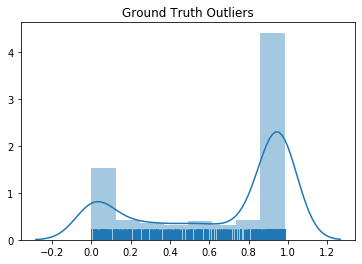

In [115]:
sns.distplot(G_outlier_scores[np.isfinite(G_outlier_scores)], 
             rug=True,)
plt.title("Ground Truth Outliers")

In [121]:
threshold:np.ndarray = pd.Series(G_outlier_scores).quantile(.9)
outliers:np.ndarray = np.where(G_outlier_scores > threshold)[0]
print(f'Total Scores > {threshold} = {len(outliers)}')

Total Scores > 0.973784851805894 = 106


# Damaged

In [124]:
D_foreground:np.ndarray = load_checkpoint('checkpoints/D_foreground.pkl')

print(D_foreground[:2])
print(D_foreground.shape)

[[0.00364477 0.00130424 0.00304495 ... 0.01756942 0.01682045 0.00175911]
 [0.02037755 0.00958439 0.00574314 ... 0.06446123 0.05637852 0.01214198]]
(128, 1056)


Initialize clusterer

In [125]:
D_clusterer:Clusterer = Clusterer(D_foreground.T, [f'm-{i}' for i in range(0,128)])

In [126]:
D_k = search_param(D_clusterer.apply_kmeans, 'n_clusters', mn=2, mx=20,)
D_km_SilScore = D_clusterer.apply_kmeans({'n_clusters': D_k})
D_kmeans = D_clusterer.kmeans
D_km_labels:list = D_kmeans.labels_
    
print('labels:', np.unique(D_km_labels, return_counts=True))
print('silhouette score:', D_km_SilScore)
print('Best K:', D_k)

labels: (array([0, 1, 2], dtype=int32), array([722, 167, 167]))
silhouette score: 0.6328212
Best K: 3
